# ltu-ili pydelfi interface
This is a tutorial for using the pydelfi inference framework in a jupyter notebook. It follows the same example as the `ltu-ili` tutorial, but uses the `pydelfi` interface instead.

This notebook assumes you have installed the ltu-ili package (**tensorflow version**) from the installation instructions in [INSTALL.md](../INSTALL.md).

In [1]:
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior


## Toy NLE
This example does inference on a toy model using Neural Likelihood Estimation (NLE).

In [2]:
# create the same synthetic catalog as the previous example
def simulator(params):
    # create toy simulations
    x = np.arange(10)
    y = 3 * params[0] * np.sin(x) + params[1] * x ** 2 - 2 * params[2] * x
    y += np.random.randn(len(x))
    return y

seed_sim = 4321
np.random.seed(seed_sim)
theta = np.random.rand(200, 3)  # 200 simulations, 3 parameters
x = np.array([simulator(t) for t in theta])

# make a dataloader
loader = NumpyLoader(x=x, theta=theta)

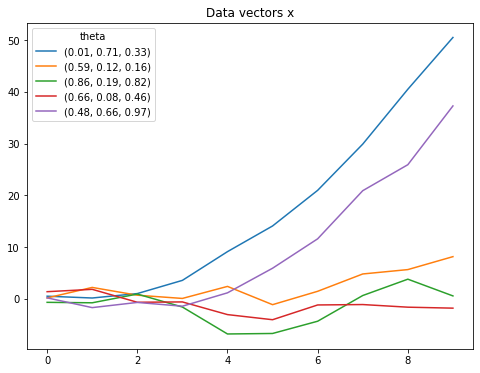

In [3]:
# plot some examples of the data
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(5):
    ind = np.random.randint(len(theta))
    ax.plot(x[ind], label=f'(%.2f, %.2f, %.2f)' % tuple(theta[ind]))
ax.legend(title='theta')
ax.set_title('Data vectors x')
plt.show()

In [4]:
# define a prior
prior = ili.utils.Uniform(low=[0, 0, 0], high=[1, 1, 1])

# instantiate your neural networks to be used as an ensemble
config_ndes = [
    {'model': 'maf', 'hidden_features':50, 'num_transforms': 5}, 
    {'model': 'mdn', 'hidden_features':50, 'num_components': 2}
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 5e-5
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='pydelfi', engine='NLE',
    prior=prior,
    config_ndes=config_ndes,
)

In [5]:
# train the model. this outputs a posterior model and training logs
posterior_ensemble, summaries = runner(loader=loader)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().



Training:  31%|███▏      | 157/500 [00:31<00:13, 24.79it/s, train loss=-2.69, val loss=0.596] 

INFO:tensorflow:Restoring parameters from tmp/graph_checkpoint


INFO:tensorflow:Restoring parameters from tmp/graph_checkpoint
Training:  65%|██████▌   | 326/500 [01:35<00:16, 10.79it/s, train loss=-1.67, val loss=1.75] 

INFO:tensorflow:Restoring parameters from tmp/graph_checkpoint


INFO:tensorflow:Restoring parameters from tmp/graph_checkpoint
Training:  65%|██████▌   | 326/500 [01:36<00:51,  3.39it/s, train loss=-1.67, val loss=1.75]



INFO:root:It took 133.03529691696167 seconds to train all models.


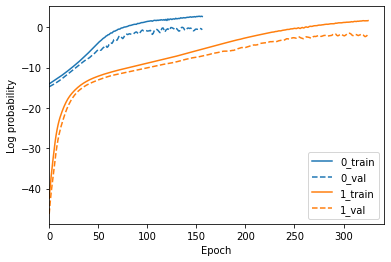

In [6]:
# plot train/validation loss
f, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [7]:
# choose a random input
seed_ind = 24
np.random.seed(seed_ind)
ind = np.random.randint(len(theta))

# generate samples from the posterior using MCMC
samples = posterior_ensemble.sample(
    (1000,), x[ind], num_chains=6
)

# calculate the potential (prop. to log_prob) for each sample
log_prob = posterior_ensemble.potential(
    samples, 
    [x[ind]]
)

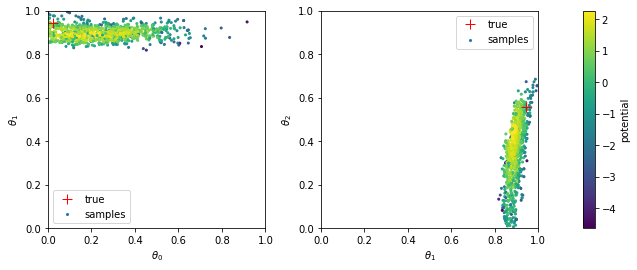

In [8]:
# plot the posterior samples and the true value
f, axs = plt.subplots(1, 3, figsize=(10,4), gridspec_kw={'width_ratios': [1,1,0.05]})
for i in range(2):
    axs[i].plot(theta[ind,i], theta[ind,i+1], 'r+', markersize=10, label='true')
    im = axs[i].scatter(samples[:,i], samples[:,i+1], c=log_prob, s=4, label='samples')
    axs[i].set_aspect('equal')
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(0,1)
    axs[i].set_xlabel(f'$\\theta_{i}$')
    axs[i].set_ylabel(f'$\\theta_{i+1}$')
    axs[i].legend()
plt.colorbar(im, label='potential', use_gridspec=True, cax=axs[2])

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [34:04<00:00, 10.22s/it]


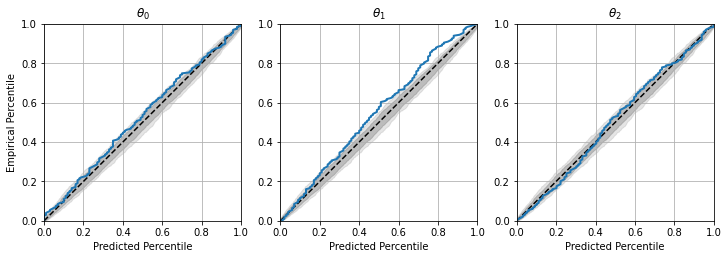

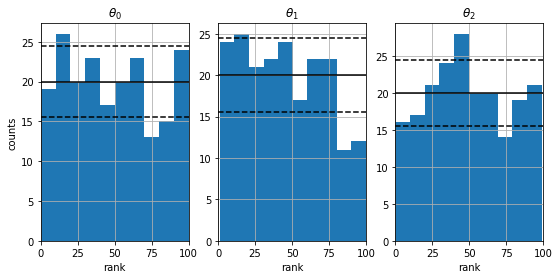

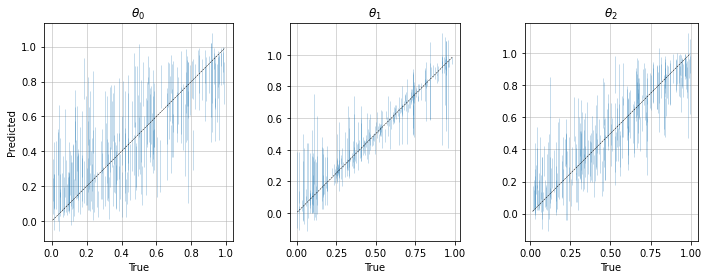

In [9]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PosteriorCoverage(
    num_samples=100,
    sample_params={'num_chains': 10},
    labels=[f'$\\theta_{i}$' for i in range(3)],
    plot_list = ["coverage", "histogram", "predictions"]
)

# Drawing samples from the ensemble posterior
fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=x, theta=theta
)